### Imports

In [42]:
import os
import sys
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Add the parent directory to the system path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)

### Globals for the plotting

In [43]:
plot_w = 6
plot_h = 18
# The above are opposite :) hehe, # TODO leeezm

plt.style.use('ggplot')
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

yellow = '#FFFF00' # Yellow
purple = '#990099' # Purple
cyan = '#00E3D4'   # Cyan

base_color = cyan
line_width_bars = 1

cr_hatching_1 = '////'
cr_hatching_2 = '\\\\\\\\'


#Output directory
output_dir = os.path.join(parent_dir, 'plotting', 'replotting_results', 'bar_plots')
os.makedirs(output_dir, exist_ok=True)

plt.rcParams['hatch.linewidth'] = 0.1 # set hatch width

scenarios_to_labels = {'advanced':'Advanced',
                       'cave':'Cave',
                       'deadend':'Deadend',
                       'helix':'Helix',
                       'horizontal':'Horizontal',
                       'house_easy':'House-easy',
                       'house_easy_obstacles':'House-easy-obs',
                       'house_hard':'House-hard',
                       'house_hard_obstacles':'House-hard-obs',
                       'vertical':'Vertical'}


### Helper functions

In [44]:
def sim_to_ep_metric_mapping(sim_metric_name): #Extend this if other metrics wanted crosscheck the report.txt and test_summary.csv for the names
    if sim_metric_name == 'Avg. Speed [m/s]':
        return 'Avg Speed'
    elif sim_metric_name == 'Avg. Absolute Path Error [m]':
        return 'Avg Absolute Path Error'
    else:
        return sim_metric_name

def extract_metric(report_path, metric_name):
    with open(report_path, 'r') as file:
        content = file.read()
        # Adjusted regex pattern to be more flexible with spaces and optional percentage sign
        match = re.search(rf'{re.escape(metric_name)}\s*\[?\%?\]?\s*([\d.]+)', content)
        if match:
            return float(match.group(1))
        else:
            return None

def collect_agent_metrics(base_dir, agent_name):
    '''
    Input: 
    base_dir - the directory where the results are stored, 
    agent_name - the name of the agent whose metrics are to be collected
    
    Output:
    metrics - a dictionary containing the average metrics for each scenario.
    n_episode_metrics - a dictionary containing the metrics over n episodes for each scenario.
    
    The Episode metrics df has the form {Collision:[n_ep metrics for scenario 1, n_ep metrics for scenario 2, ...], 
                                            Success: [n_ep metrics for scenario 1, n_ep metrics for scenario 2, ...], 
                                            ...}
    
    The code assumes that the test scenarios appear in the same order in the ../resultsgen/agent_name folder.
    '''                

    metrics = {
        'Collision Rate': [],
        'Success Rate': [],
        'Progression': [],
        'Avg. Number of Timesteps': [],
        'Avg. Speed [m/s]': [],
        'Avg. Absolute Path Error [m]': []
    }
    scenarios = []
    n_episode_metrics = {
        'Collision': [],
        'Success': [],
        'Progression': [],
        'Timesteps': [],
        'Avg Speed': [],
        'Avg Absolute Path Error': []
    }

    for test_scen in os.listdir(base_dir):
        test_scen_dir = os.path.join(base_dir, test_scen)
        if os.path.isdir(test_scen_dir):
            agent_dir_path = os.path.join(test_scen_dir, agent_name)
            report_path = os.path.join(agent_dir_path, 'report.txt')
            csv_path = os.path.join(agent_dir_path, 'test_summary.csv')
            if os.path.exists(report_path):
                for metric_name in metrics.keys():
                    metric_value = extract_metric(report_path, metric_name)
                    if metric_value is not None:
                        metrics[metric_name].append(metric_value)
                scenarios.append(test_scen)
            if os.path.exists(csv_path):
                n_ep_metrics_df = pd.read_csv(csv_path)
                for metric_name in n_episode_metrics.keys():
                    n_episode_metrics[metric_name].append(n_ep_metrics_df[metric_name].values)


    return metrics, n_episode_metrics, scenarios


def reorder_data(metrics, n_episode_metrics, scenarios):
    #When deadend
    # reordering = {2:0, #helix 
    #               0:1, #cave
    #               8:2, #vertical
    #               3:3, #horizontal
    #               1:4, #deadend
    #               4:5, #house easy
    #               5:6, #house easy obstacles
    #               6:7, #house hard
    #               7:8} #house hard obstacles

    #When no deadend and advanced added:    
    reordering = {
            0:0, #advanced
            2:1, #helix
            3:2, #horizontal
            8:3, #vertical
            1:4, #cave
            4:5, #house easy
            5:6, #house easy obstacles
            6:7, #house hard
            7:8, #house hard obstacles
            } 

    for metric, m_list in metrics.items():
        new_metric_list = [0,0,0,0,0,0,0,0]
        for i in range(len(m_list)):
            new_metric_list[reordering[i]] = m_list[i]
        metrics[metric] = new_metric_list

    for metric, m_list in n_episode_metrics.items():
        new_metric_list = [0,0,0,0,0,0,0,0]
        for i in range(len(m_list)):
            new_metric_list[reordering[i]] = m_list[i]
        n_episode_metrics[metric] = new_metric_list

    new_scenarios = [0,0,0,0,0,0,0,0]
    for i in range(len(scenarios)):
        new_scenarios[reordering[i]] = scenarios[i]
    scenarios = new_scenarios

    return metrics, n_episode_metrics, scenarios


def calculate_confidence_intervals(n_episode_metrics): 
    confidence_intervals = {}
    for metric_name, values in n_episode_metrics.items():
        means = [np.mean(v) for v in values]
        sems = [np.std(v)/np.sqrt(len(v)) for v in values]
        cis = [1.96 * sem for sem in sems]
        confidence_intervals[metric_name] = (means, cis)
    return confidence_intervals


### Plotting functions

In [45]:
def visualize_metrics(metrics, scenarios, metric_name, ylabel, show_ci=False, episode_metrics=None):
    values = metrics[metric_name]
    if show_ci:
        ep_metric_name = sim_to_ep_metric_mapping(metric_name)
        means, cis = calculate_confidence_intervals(episode_metrics)[ep_metric_name]


    fig, ax = plt.subplots(figsize=(plot_h, plot_w))
    if show_ci:
        ax.bar(scenarios, means, yerr=cis, color=base_color, edgecolor='black', linewidth=line_width_bars, capsize=5)
    else:
        ax.bar(scenarios, values, color=base_color, edgecolor='black', linewidth=line_width_bars)
    ax.set_xlabel('Scenarios')
    ax.set_ylabel(ylabel)
    ax.set_xticks(range(len(scenarios)))
    scenarios_labels = [scenarios_to_labels[scen] for scen in scenarios]
    ax.set_xticklabels(scenarios_labels)#, rotation=45, ha='right')
    # ax.set_xticklabels(scenarios, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# def visualize_percentages_together_one_agent(metrics, scenarios): #Unused
#     metric_names = ['Success Rate', 'Collision Rate', 'Progression']
#     colors = ['#00E3D4', '#F68AF0', '#3343A7'] # cyan, pink, blue
#     percentage_metrics = {name: metrics[name] for name in metric_names}

#     x = np.arange(len(scenarios))
#     width = 0.2

#     fig, ax = plt.subplots(figsize=(12, 8))
    
#     for i, (metric_name, values) in enumerate(percentage_metrics.items()):
#         ax.bar(x + width*i, values, width, label=metric_name, color=colors[i])

#     ax.set_xlabel('Scenarios')
#     ax.set_ylabel('Percentage')
#     ax.set_xticks(x + width)
#     ax.set_xticklabels(scenarios, rotation=45, ha='right')
#     ax.legend()
#     plt.tight_layout()
#     plt.show()

def visualize_two_agents(metrics1, metrics2, scenarios, metric_name, ylabel, show_ci=False, episode_metrics1 =None, episode_metrics2=None, label1='Agent 1', label2='Agent 2',save_to_file=False):
    values1 = metrics1[metric_name]
    values2 = metrics2[metric_name]

    if show_ci:
        ep_metric_name = sim_to_ep_metric_mapping(metric_name)
        means1, cis1 = calculate_confidence_intervals(episode_metrics1)[ep_metric_name]
        means2, cis2 = calculate_confidence_intervals(episode_metrics2)[ep_metric_name]
    
    if metric_name == "Progression":
        values1 = [v*100 for v in values1]
        values2 = [v*100 for v in values2]
        means1 = [v*100 for v in means1]
        means2 = [v*100 for v in means2]
        cis1 = [v*100 for v in cis1]
        cis2 = [v*100 for v in cis2]

    x = np.arange(len(scenarios))
    width = 0.4
    
    fig, ax = plt.subplots(figsize=(plot_h, plot_w))
    if show_ci:
        ax.bar(x - width/2, means1, width, yerr=cis1, label=label1, color=base_color, edgecolor='black', linewidth=line_width_bars,error_kw=dict(lw=line_width_bars/2, capsize=5))
        ax.bar(x + width/2, means2, width, yerr=cis2, label=label2, color='#F6DEB8', edgecolor='black', linewidth=line_width_bars,error_kw=dict(lw=line_width_bars/2, capsize=5))
    else:
        ax.bar(x - width/2, values1, width, label=label1, color=base_color, edgecolor='black', linewidth=line_width_bars)
        ax.bar(x + width/2, values2, width, label=label2, color='#F6DEB8', edgecolor='black', linewidth=line_width_bars)

    ax.set_xlabel('Scenarios')
    ax.set_ylabel(ylabel)
    scenarios_labels = [scenarios_to_labels[scen] for scen in scenarios]
    ax.set_xticks(x)
    ax.set_xticklabels(scenarios_labels)#, rotation=45, ha='right')
    ax.legend(fontsize=12)

    if save_to_file:
        ep_metric_name = sim_to_ep_metric_mapping(metric_name) #hacky fix since the sim_df metric names are illegal for file names
        plt.savefig(os.path.join(output_dir, f'{label1}_and_{label2}_{ep_metric_name}.pdf'), bbox_inches = 'tight')

    plt.tight_layout()
    plt.show()

def visualize_stacked_SR_CR(metrics1, scenarios, metrics2=None, agent_name1=None, agent_name2=None,save_to_file=False):
    x = np.arange(len(scenarios))
    width = 0.4
    colors = [yellow,"blank",purple] # yellow, blank, purple
    # colors = ['#00E3D4', '#F68AF0', '#3343A7'] # cyan, pink, blue
    # colors = ['#008B8B', 'magenta', '#89CFF0'] # Dark cyan, magenta, baby blue
    # colors = ['#F6DEB8', '#A23C9D', '#FF7F50'] # tan darkmagenta coral
    fig, ax = plt.subplots(figsize=(plot_h, plot_w))

    if metrics2 is None:
        success_rates = metrics1['Success Rate']
        collision_rates = metrics1['Collision Rate']

        ax.bar(x, collision_rates, width, label='Collision Rate', color=colors[2], edgecolor='black', linewidth=line_width_bars)
        ax.bar(x, success_rates, width, bottom=collision_rates, label='Success Rate', color=colors[0], edgecolor='black', linewidth=line_width_bars)

    else:
        success_rates1 = metrics1['Success Rate']
        success_rates2 = metrics2['Success Rate']
        collision_rates1 = metrics1['Collision Rate']
        collision_rates2 = metrics2['Collision Rate']

        #ax.bar(x - width/2, success_rates1, width,  label=f'Success Rate {agent_name1}', color=colors[2], edgecolor='black', linewidth=line_width_bars)
        #ax.bar(x + width/2, success_rates2, width,  label=f'Success Rate {agent_name2}', color=colors[0], edgecolor='black', linewidth=line_width_bars)
        
        #ax.bar(x - width/2, collision_rates1, width, bottom=success_rates1, label=f'Collision Rate {agent_name1}', color=colors[2], hatch=cr_hatching_1, edgecolor='black', linewidth=line_width_bars)
        #ax.bar(x + width/2, collision_rates2, width, bottom=success_rates2, label=f'Collision Rate {agent_name2}', color=colors[0], hatch=cr_hatching_2, edgecolor='black', linewidth=line_width_bars)

        ax.bar(x - width/2, success_rates1, width,  label=f'Success Rate {agent_name1}', color=colors[0], edgecolor='black', linewidth=line_width_bars)
        ax.bar(x + width/2, success_rates2, width,  label=f'Success Rate {agent_name2}', color=colors[0], edgecolor='black', hatch=cr_hatching_1, linewidth=line_width_bars)
        
        ax.bar(x - width/2, collision_rates1, width, bottom=success_rates1, label=f'Collision Rate {agent_name1}', color=colors[2], edgecolor='black', linewidth=line_width_bars)
        ax.bar(x + width/2, collision_rates2, width, bottom=success_rates2, label=f'Collision Rate {agent_name2}', color=colors[2], hatch=cr_hatching_2, edgecolor='black', linewidth=line_width_bars)

    ax.set_xlabel('Scenarios')
    #ax.set_ylabel('Percentage')
    scenarios_labels = [scenarios_to_labels[scen] for scen in scenarios]
    ax.set_xticks(x)
    ax.set_xticklabels(scenarios_labels)#, rotation=45, ha='right')

    # Custom legend
    if agent_name1 is None:
        colors = {'Success rate':colors[0], 'Collision rate':colors[2]}
    else:
        colors = {'Success rate':colors[0], 'Collision rate':colors[2], f'{agent_name1}':'white', f'{agent_name2}':'white'}         
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, facecolor=colors[label], edgecolor='black') for label in labels[:3]] + [plt.Rectangle((0,0),1,1, facecolor=colors[label], edgecolor='black', hatch=cr_hatching_1) for label in labels[3:]]
    ax.legend(handles, labels, ncols=2, fontsize=12)

    #ax.legend()
    
    # Do not show ylabels greater than 100, and display every 20%
    ax.set_ylim(bottom=0)
    ax.set_yticks(np.arange(0, 101, 20))
    ax.set_yticklabels([f'{i}%' for i in range(0, 101, 20)])

    ax.set_ylim(top=ax.get_ylim()[1] * 1.18)#26)  # Increase the upper limit by 26% to fit legend
    
    if save_to_file:
        plt.savefig(os.path.join(output_dir, f'{agent_name1}_and_{agent_name2}_SR_CR.pdf'), bbox_inches = 'tight')
        
    plt.tight_layout()
    plt.show()

### Available metrics:
```'Collision Rate'```

```'Success Rate'```

```'Progression'```

```'Avg. Number of Timesteps'```

```'Avg. Speed [m/s]'```

```'Avg. Absolute Path Error [m]'```

### Loading the agents and colleting metrics

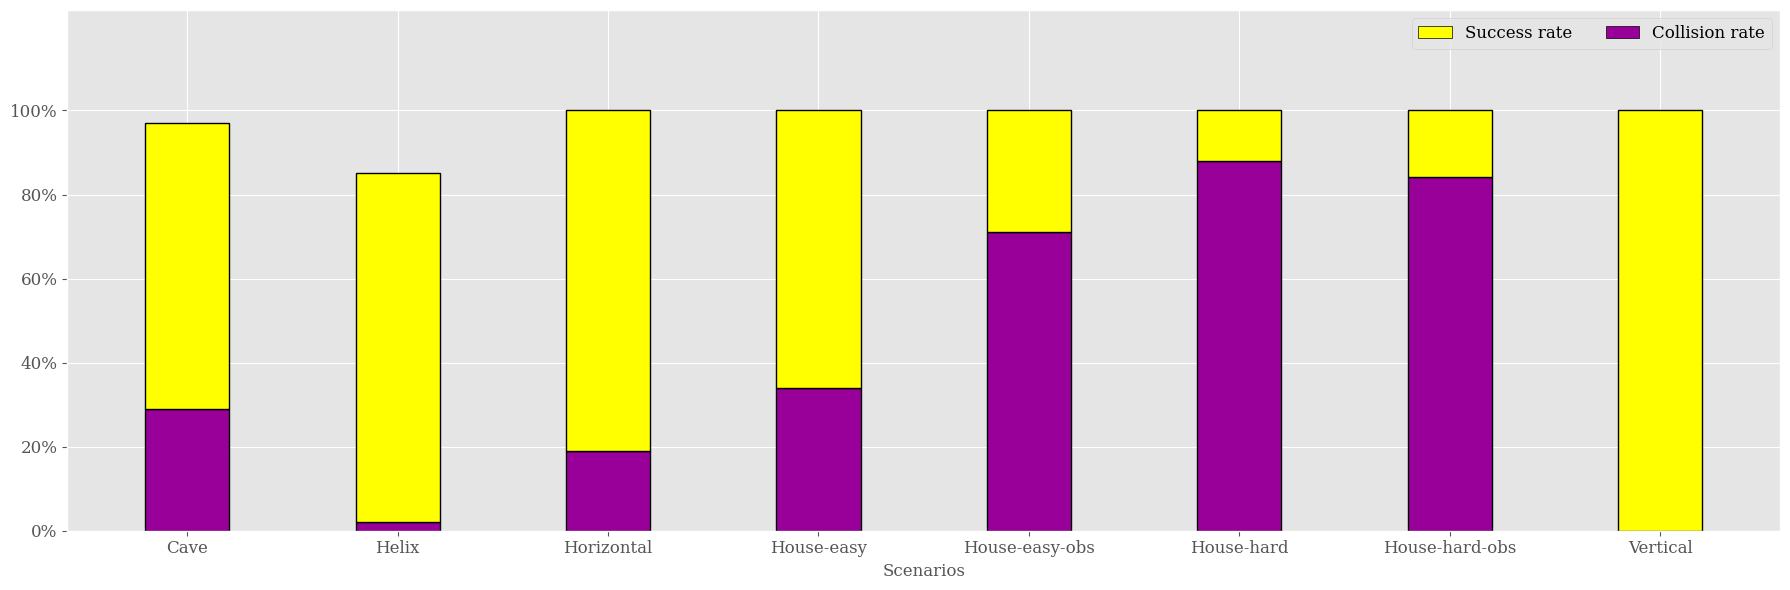

In [46]:
#### The random agent ####
exp_dir_path = 'Best_agent_res_gen_2 exp 32'
trained_scen = "advanced"
base_dir = f'../log/LV_VAE_MESH-v0/{exp_dir_path}/{trained_scen}/results_gen'

agent_name = "test_agent_model_10000"
metrics1, n_ep_met1, scenarios1 = collect_agent_metrics(base_dir, agent_name)

# metrics1, n_ep_met1, scenarios1, reorder_data(metrics1, n_ep_met1, scenarios1)

#### The locked conv agent ####
# exp_dir_path = 'Best_agent_res_gen_1 exp 10005'
# trained_scen = "proficient_perturbed"
# base_dir = f'../log/LV_VAE_MESH-v0/{exp_dir_path}/{trained_scen}/results_gen'

# agent_name = "test_agent_model_180000"
# metrics2,n_ep_met2, scenarios2 = collect_agent_metrics(base_dir,agent_name)

####The unlocked agent #### worse than the two above
# exp_dir_path = 'A_maybe_best_pt_unlocked 10006'
# trained_scen = "expert_perturbed"
# base_dir = f'../log/LV_VAE_MESH-v0/{exp_dir_path}/{trained_scen}/results_gen'
# agent_name = "test_agent_model_30000"
# metrics3,n_ep_met3, scenarios3 = collect_agent_metrics(base_dir, agent_name)


# assert scenarios1 == scenarios2 

visualize_stacked_SR_CR(metrics1, scenarios1 ,save_to_file=True)

# visualiz

Note that the displayed hatchin does not reflect the real plot. See the pdf to real result.

In [47]:
# visualize_two_agents(metrics1, metrics2, scenarios1, 'Progression', 'Avg. progression [%]',label1='random', label2='locked conv',show_ci=True, episode_metrics1=n_ep_met1, episode_metrics2=n_ep_met2,save_to_file=True)

In [48]:
# visualize_two_agents(metrics1, metrics2, scenarios1, 'Avg. Speed [m/s]', 'Avg. speed [m/s]',label1='random', label2='locked conv', show_ci=True, episode_metrics1=n_ep_met1, episode_metrics2=n_ep_met2,save_to_file=True)

In [49]:
# visualize_two_agents(metrics1, metrics2, scenarios1, 'Avg. Absolute Path Error [m]', 'Avg. path deviance [m]',label1='random', label2='locked conv', show_ci=True, episode_metrics1=n_ep_met1, episode_metrics2=n_ep_met2,save_to_file=True)

### Single plotting, not used honestly

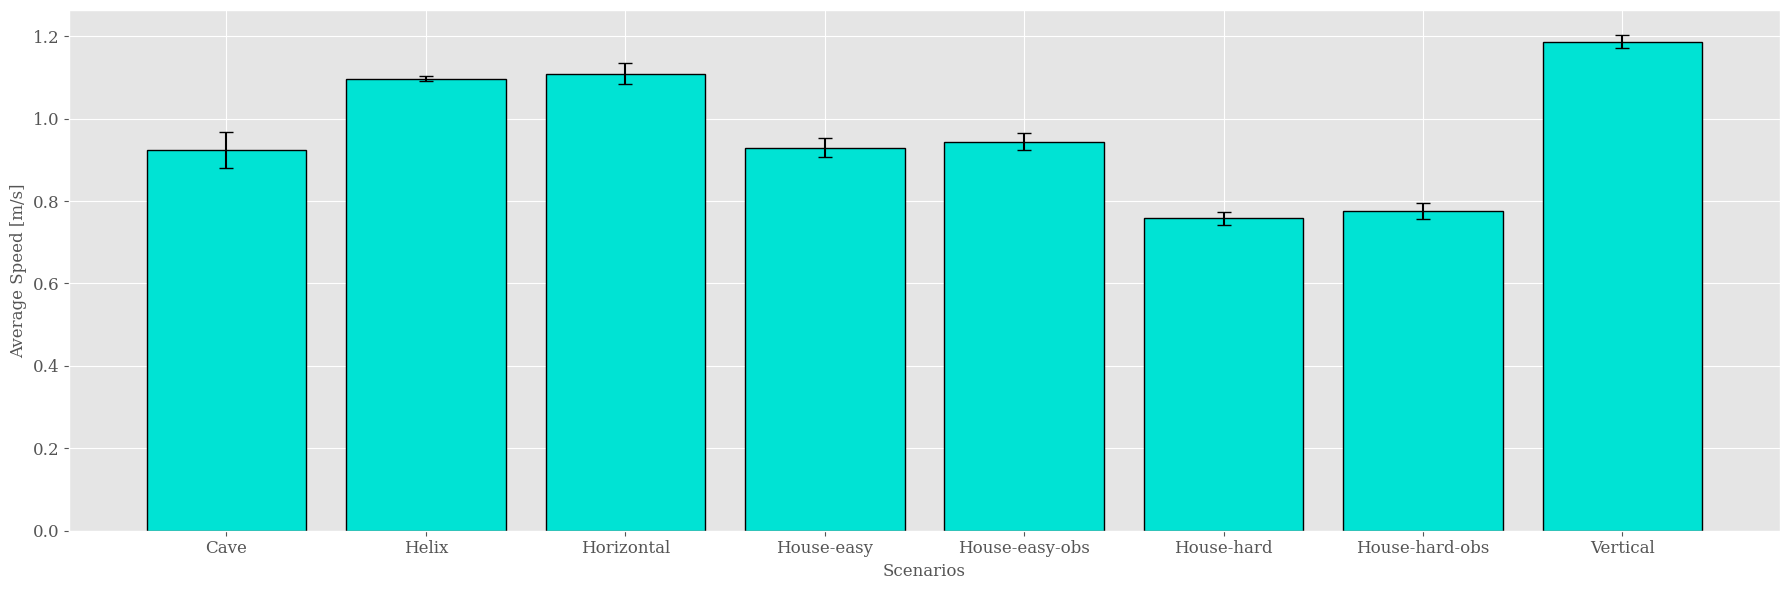

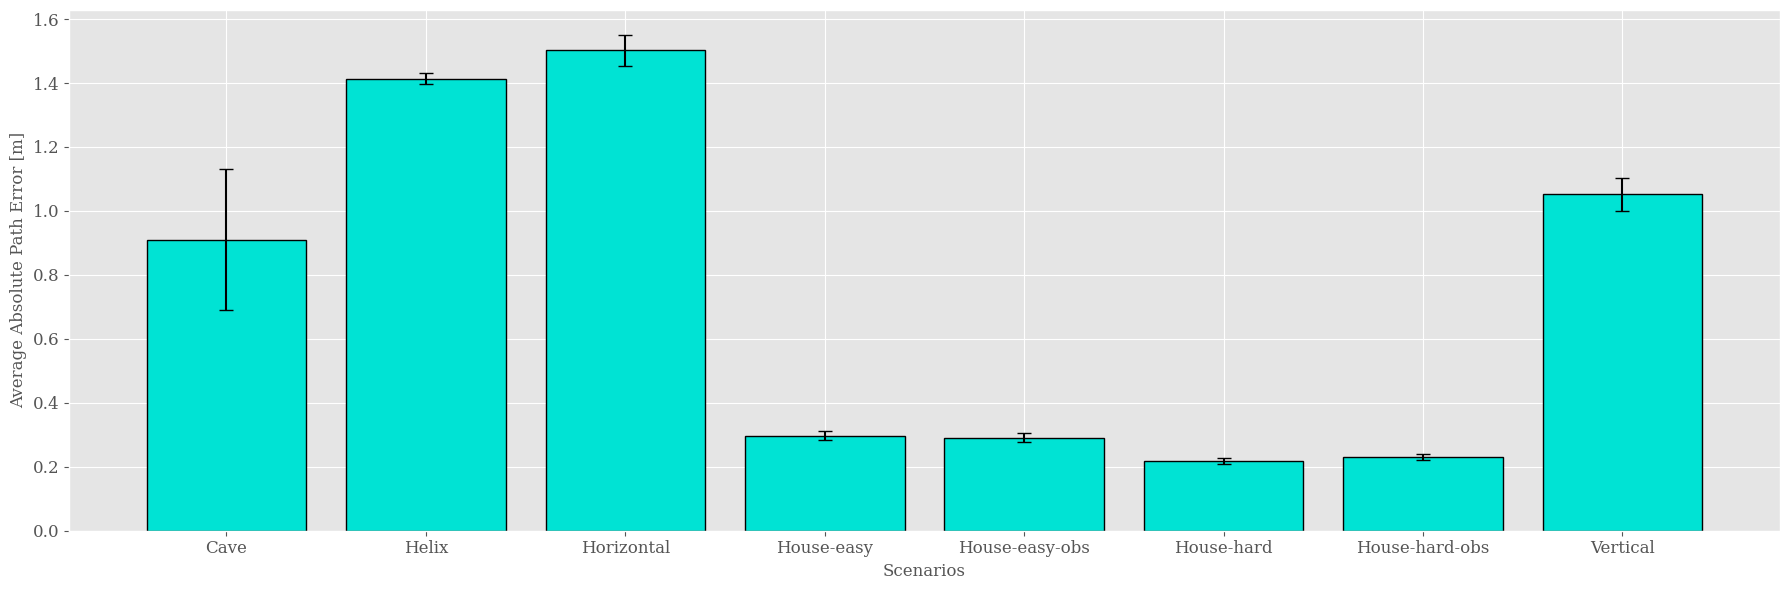

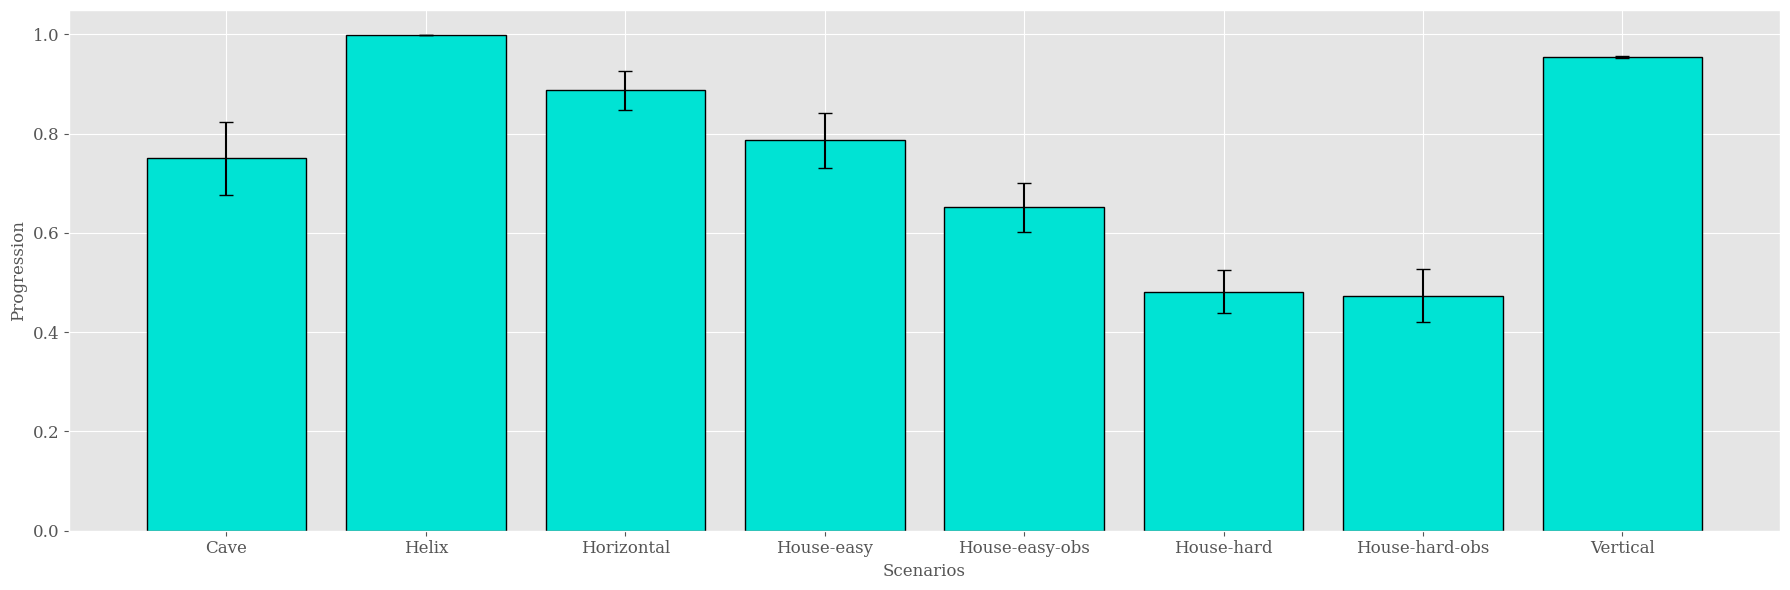

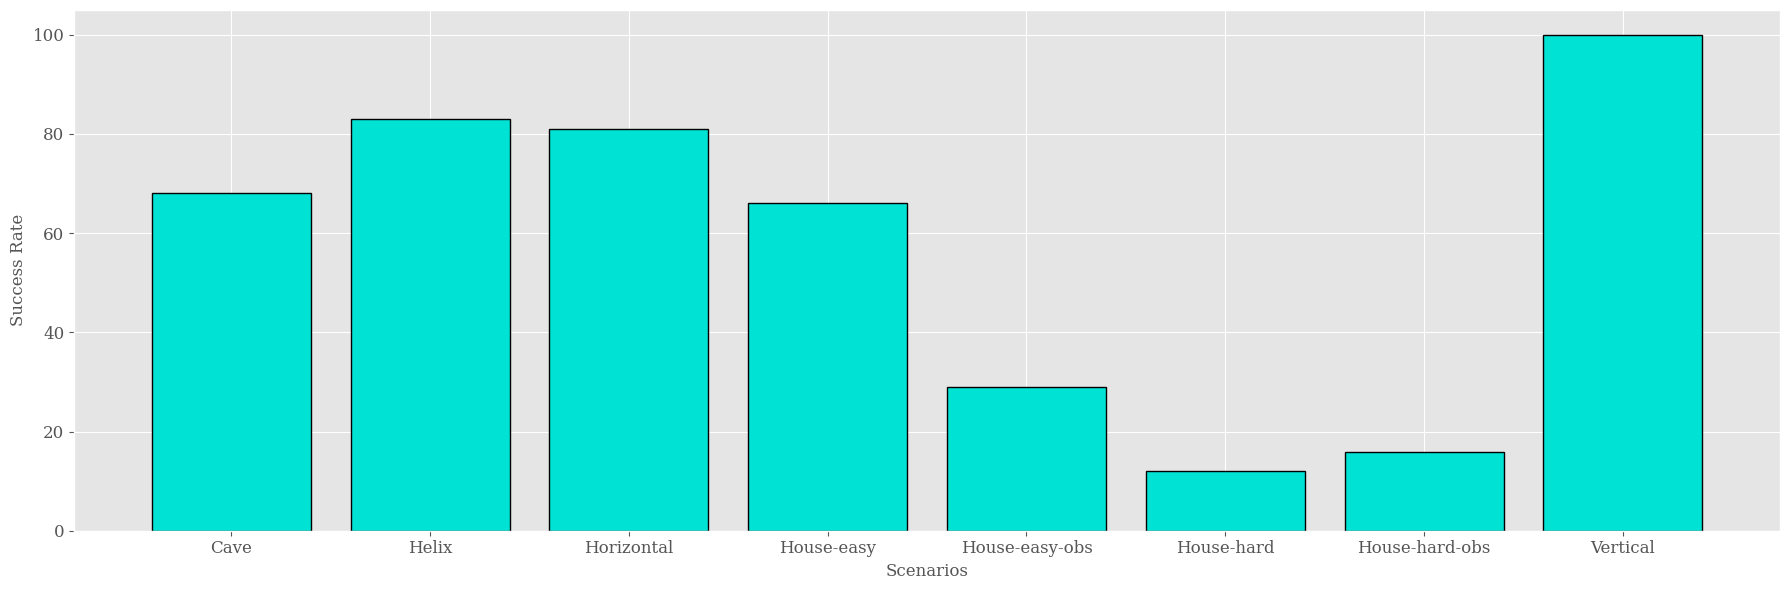

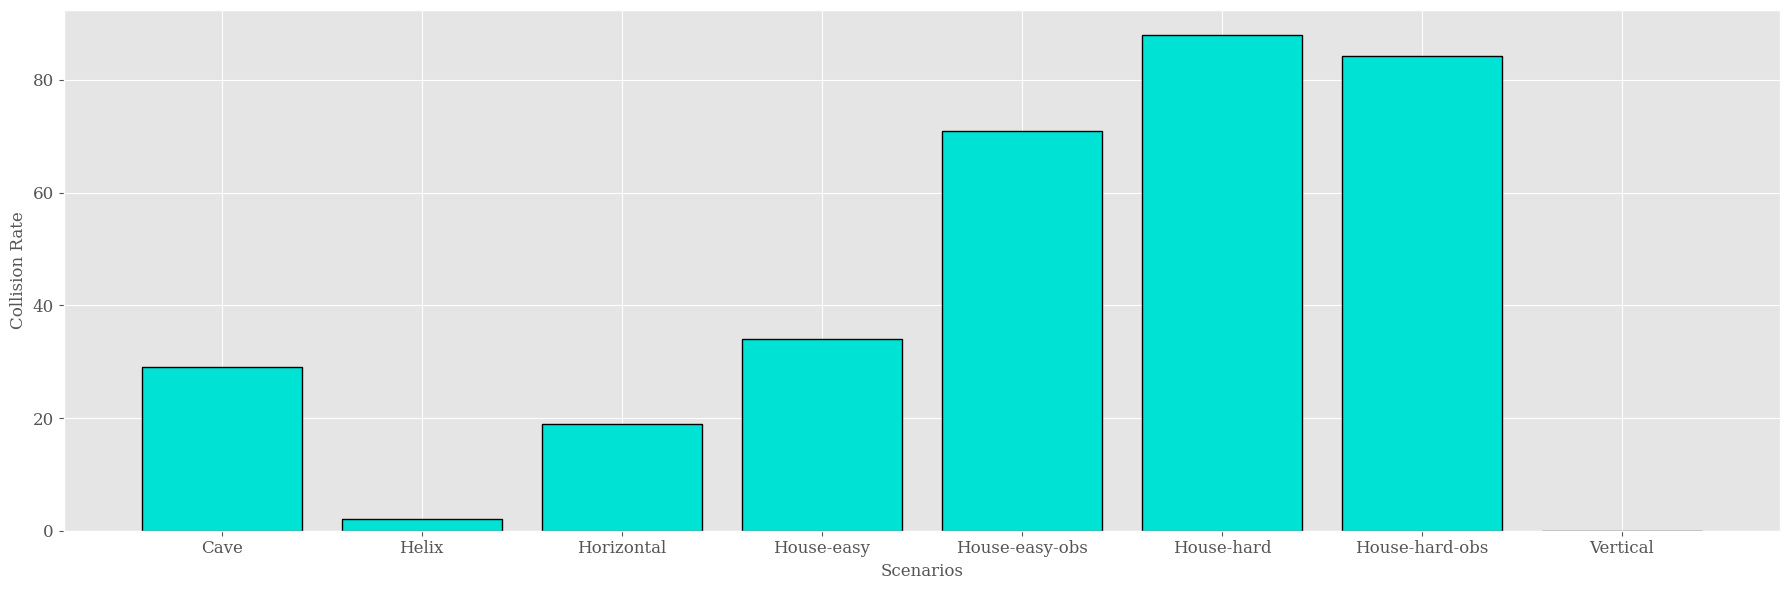

In [50]:
exp_id = 32
trained_scen = "advanced"
agent_name = "test_agent_model_10000" 
exp_dir_path = f'Best_agent_res_gen_2 exp {exp_id}'
base_dir = f'../log/LV_VAE_MESH-v0/{exp_dir_path}/{trained_scen}/results_gen'

metrics, epmet, scenarios = collect_agent_metrics(base_dir, agent_name)
# For single metric visualization
#The metrics that need CI
visualize_metrics(metrics, scenarios, 'Avg. Speed [m/s]', 'Average Speed [m/s]', show_ci=True, episode_metrics=epmet)
visualize_metrics(metrics, scenarios, 'Avg. Absolute Path Error [m]', 'Average Absolute Path Error [m]', show_ci=True, episode_metrics=epmet)
visualize_metrics(metrics, scenarios, 'Progression', 'Progression', show_ci=True, episode_metrics=epmet)
#Percentages dont need CI (?)
visualize_metrics(metrics, scenarios, 'Success Rate', 'Success Rate')
visualize_metrics(metrics, scenarios, 'Collision Rate', 'Collision Rate')
# visualize_metrics(metrics, scenarios, 'Avg. Number of Timesteps', 'Average Number of Timesteps') #Unused

# For combined percentage metrics visualization (unused)
# visualize_percentages_together_one_agent(metrics, scenarios)